<a href="https://colab.research.google.com/github/dksifoua/Question-Answering/blob/master/1%20-%20Document%20reader%20Question%20Answering%20-%20DrQA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Sun Oct 11 07:12:52 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Load Dependencies

In [2]:
!pip install tqdm --upgrade >> /dev/null 2>&1
!pip install torchtext --upgrade >> /dev/null 2>&1
!pip install spacy --upgrade >> /dev/null 2>&1
!python -m spacy download en >> /dev/null 2>&1

In [3]:
import re
import json
import tqdm
import spacy
import warnings
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.display import display, HTML

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchtext.data import Dataset, Example, Field
from torchtext.data.iterator import BucketIterator
from torchtext.data.metrics import bleu_score

In [4]:
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

SEED = 546
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {DEVICE}')

Device: cuda


## Prepare data

***Download data***

In [5]:
%%time
!mkdir -p ./data

!wget --no-check-certificate \
    https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json \
    -O ./data/train.json

!wget --no-check-certificate \
    https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json \
    -O ./data/valid.json

--2020-10-11 07:13:20--  https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42123633 (40M) [application/json]
Saving to: ‘./data/train.json’

./data/train.json   100%[===================>]  40.17M   135MB/s    in 0.3s    

2020-10-11 07:13:20 (135 MB/s) - ‘./data/train.json’ saved [42123633/42123633]

--2020-10-11 07:13:20--  https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4370528 (4.2M) [application/json]
Saving to: ‘./data/valid.json’

./data/valid.

***Load data***

In [6]:
def load_json(path):
    with open(path, mode='r', encoding='utf-8') as file:
        return json.load(file)['data']

train_raw = load_json(path='./data/train.json')
valid_raw = load_json(path='./data/valid.json')
print(f'Length of raw train data: {len(train_raw):,}')
print(f'Length of raw valid data: {len(valid_raw):,}')

Length of raw train data: 442
Length of raw valid data: 35


***Parse data***

In [7]:
def parse_json(data):
    qas = []
    for paragraphs in data:
        for para in paragraphs['paragraphs']:
            context = re.sub(r'\s', ' ', para['context'])
            for qa in para['qas']:
                id = qa['id']
                question = re.sub(r'\s', ' ', qa['question'])
                for ans in qa['answers']:
                    answer = re.sub(r'\s', ' ', ans['text'])
                    ans_start = ans['answer_start']
                    qas.append({
                        'id': id,
                        'context': context,
                        'question': question,
                        'answer': answer,
                        'answer_start': ans_start,
                    })
    return qas

train_qas = parse_json(train_raw)
valid_qas = parse_json(valid_raw)
print(f'Length of train qa pairs: {len(train_qas):,}')
print(f'Length of valid qa pairs: {len(valid_qas):,}')

print('Id:', train_qas[0]['id'])
print('Context:', train_qas[0]['context'])
print('Question:', train_qas[0]['question'])
print('Answer starts at:', train_qas[0]['answer_start'])
print('Answer:', train_qas[0]['answer'])

for i in range(len(train_qas)): # Test labels are correct in train set
    assert train_qas[i]['answer'] == train_qas[i]['context'][train_qas[i]['answer_start']:train_qas[i]['answer_start']+len(train_qas[i]['answer'])]

for i in range(len(valid_qas)): # Test labels are correct in validation set
    assert valid_qas[i]['answer'] == valid_qas[i]['context'][valid_qas[i]['answer_start']:valid_qas[i]['answer_start']+len(valid_qas[i]['answer'])]

Length of train qa pairs: 86,821
Length of valid qa pairs: 20,302
Id: 56be85543aeaaa14008c9063
Context: Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".
Question: When did Beyonce start becoming popular?
Answer starts at: 269
Answer: in the late 1990s


***Add targets***

In [8]:
%%time
def add_targets(qas, nlp=spacy.load('en')):
    for qa in tqdm.tqdm(qas):
        context = nlp(qa['context'], disable=['parser','tagger','ner'])
        answer = nlp(qa['answer'], disable=['parser','tagger','ner'])
        ans_start = qa['answer_start']
        for i in range(len(context)):
            if context[i].idx == ans_start:
                ans = context[i:i + len(answer)]
                qa['target'] = (ans[0].i, ans[-1].i)
                break

def filter_qas(qa, nlp=spacy.load('en')):
    if 'target' in [*qa.keys()]:
        context = nlp(qa['context'], disable=['parser','tagger','ner'])
        start, end = qa['target']
        return context[start:end+1].text == qa['answer']
    return False

def test_targets(qas, nlp=spacy.load('en')):
    for qa in tqdm.tqdm(qas):
        if 'target' in [*qa.keys()]:
            context = nlp(qa['context'], disable=['parser','tagger','ner'])
            start, end = qa['target']
            assert context[start:end + 1].text == qa['answer'], f"{context[start:end + 1].text} -- {qa['answer']}"

add_targets(train_qas)
add_targets(valid_qas)
print()
print(f'Length of train qa pairs before filtering out bad qa pairs: {len(train_qas):,}')
print(f'Length of valid qa pairs before filtering out bad qa pairs: {len(valid_qas):,}')
train_qas = [*filter(filter_qas, train_qas)]
valid_qas = [*filter(filter_qas, valid_qas)]
print()
print(f'Length of train qa pairs after filtering out bad qa pairs: {len(train_qas):,}')
print(f'Length of valid qa pairs after filtering out bad qa pairs: {len(valid_qas):,}')
test_targets(train_qas, spacy.load('en'))
test_targets(valid_qas, spacy.load('en'))

100%|██████████| 20302/20302 [00:23<00:00, 860.10it/s]



Length of train qa pairs before filtering out bad qa pairs: 86,821
Length of valid qa pairs before filtering out bad qa pairs: 20,302

Length of train qa pairs after filtering out bad qa pairs: 85,835
Length of valid qa pairs after filtering out bad qa pairs: 20,094


100%|██████████| 20094/20094 [00:12<00:00, 1623.64it/s]

CPU times: user 5min 13s, sys: 1.9 s, total: 5min 15s
Wall time: 5min 15s


***Build datasets***

In [9]:
ID = Field(batch_first=True)
TEXT = Field(lower=True, tokenizer_language='en', tokenize='spacy', batch_first=True)
TARGET = Field(sequential=False, use_vocab=False, batch_first=True)

In [10]:
train_dataset = Dataset([Example.fromdict(data=qa, fields={
    'id': ('id', TEXT),
    'context': ('cxt', TEXT),
    'question': ('qst', TEXT),
    'answer': ('ans', TEXT),
    'target': ('trg', TARGET)
}) for qa in tqdm.tqdm(train_qas)], fields={'cxt': TEXT, 'qst': TEXT,
                                            'ans': TEXT, 'trg': TARGET})
valid_dataset = Dataset([Example.fromdict(data=qa, fields={
    'id': ('id', TEXT),
    'context': ('cxt', TEXT),
    'question': ('qst', TEXT),
    'answer': ('ans', TEXT),
    'target': ('trg', TARGET)
}) for qa in tqdm.tqdm(valid_qas)], fields={'cxt': TEXT, 'qst': TEXT,
                                            'ans': TEXT, 'trg': TARGET})
print()
print(f'Train dataset size: {len(train_dataset.examples):,}')
print(f'valid dataset size: {len(valid_dataset.examples):,}')

100%|██████████| 20094/20094 [00:34<00:00, 581.76it/s]


Train dataset size: 85,835
valid dataset size: 20,094


In [11]:
%%time
# Build vocabulary
TEXT.build_vocab(train_dataset)
ID.build_vocab([*map(lambda x: x.id, train_dataset.examples)] + [*map(lambda x: x.id, valid_dataset.examples)])
print(f'Length of vocabulary: {len(TEXT.vocab):,}')
print(f'Length of ids: {len(ID.vocab):,}')

Length of vocabulary: 91,390
Length of ids: 91,740
CPU times: user 2.95 s, sys: 21 ms, total: 2.97 s
Wall time: 2.97 s


***Download pretrained GloVe embedding***

In [12]:
%%time
!mkdir -p ./data
!wget --no-check-certificate \
    http://nlp.stanford.edu/data/glove.840B.300d.zip \
    -O ./data/glove.840B.300d.zip

--2020-10-11 07:21:35--  http://nlp.stanford.edu/data/glove.840B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.840B.300d.zip [following]
--2020-10-11 07:21:35--  https://nlp.stanford.edu/data/glove.840B.300d.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip [following]
--2020-10-11 07:21:35--  http://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2176768927 (2.0G) [application/zip

In [13]:
!unzip -q ./data/glove.840B.300d.zip -d ./data
!rm -r ./data/glove.840B.300d.zip

In [14]:
def load_glove(path):
    glove = {}
    with open(path, mode='r', encoding='utf-8') as file:
        for line in tqdm.tqdm(file):
            values = line.split(' ')
            glove[values[0]] = np.asarray(values[1:], dtype='float32')
        return glove

glove = load_glove(path='./data/glove.840B.300d.txt')

2196017it [02:52, 12756.26it/s]


In [15]:
def load_embeddings(glove, field, embedding_size=300, most_common=1000):
    most_common_words, most_common_indexes = [*map(lambda x: x[0], field.vocab.freqs.most_common(most_common))], []
    embedding_matrix = np.zeros((len(field.vocab), embedding_size))
    n_words = 0
    for index, word in tqdm.tqdm(enumerate(field.vocab.freqs), total=len(field.vocab)):
        if word in most_common_words:
            most_common_indexes.append(index)
        try:
            embedding_matrix[index] = glove[word]
            n_words += 1
        except KeyError:
            pass
    return embedding_matrix, n_words, most_common_indexes

embedding_matrix, n_words, most_common_indexes = load_embeddings(glove, TEXT)
print(f'Words found: {n_words}/{len(TEXT.vocab)}')
np.save('./data/GloVe_DrQA.npy', embedding_matrix)

100%|█████████▉| 91388/91390 [00:01<00:00, 49379.51it/s]


Words found: 64718/91390


## Modeling

***Stacked Bidirectional LSTM Layer***

In [16]:
class StackedBiLSTMLayer(nn.Module):

    def __init__(self, input_size, hidden_size, n_layers, dropout):
        super(StackedBiLSTMLayer, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout = nn.Dropout(p=dropout)
        self.lstms = nn.ModuleList([nn.LSTM(input_size=hidden_size * 2 if i > 0 else input_size, hidden_size=hidden_size,
                                            bidirectional=True, batch_first=True) for i in range(n_layers)])
    
    def forward(self, inputs):
        """
        :param Tensor[batch_size, seq_len, input_size]
        :return Tensor[batch_size, seq_len, hidden_size * n_layers * 2]
        """
        outputs = [inputs]
        for i, lstm in enumerate(self.lstms):
            out, _ = lstm(self.dropout(outputs[-1])) # [batch_size, seq_len, hidden_size * 2]
            outputs.append(out)
        outputs = torch.cat(outputs[1:], dim=-1) # [batch_size, seq_len, hidden_size * n_layers * 2]
        return self.dropout(outputs)

***Align Question Embedding Layer***

In [17]:
class AlignQuestionEmbeddingLayer(nn.Module):

    def __init__(self, hidden_size):
        super(AlignQuestionEmbeddingLayer, self).__init__()
        self.hidden_size = hidden_size
        self.fc = nn.Linear(hidden_size, hidden_size)
    
    def forward(self, cxt, qst, qst_mask):
        """
        :param Tensor[batch_size, cxt_len, hidden_size] cxt
        :param Tensor[batch_size, qst_len, hidden_size] qst
        :param Tensor[batch_size, qst_len] mask
        :return Tensor[batch_size, cxt_len, hidden_size] context
        """
        cxt = F.relu(self.fc(cxt)) # [batch_size, cxt_len, hidden_size]
        qst = F.relu(self.fc(qst)) # [batch_size, qst_len, hidden_size]
        scores = torch.bmm(cxt, qst.transpose(-1, -2)) # [batch_size, cxt_len, qst_len]
        if qst_mask is not None:
            scores = scores.masked_fill(qst_mask.unsqueeze(1) == 0, 1e-18)
        attention_weights = F.softmax(scores, dim=-1) # [batch_size, cxt_len, qst_len]
        context = torch.bmm(attention_weights, qst) # [batch_size, cxt_len, hidden_size]
        return context

***Question Encoding Layer***

In [18]:
class QuestionEncodingLayer(nn.Module):

    def __init__(self, hidden_size):
        super(QuestionEncodingLayer, self).__init__()
        self.hidden_size = hidden_size
        self.W = nn.Linear(hidden_size, 1)
    
    def forward(self, qst_sequences, qst_mask):
        """
        :param Tensor[batch_size, seq_len, hidden_size] qst_sequences
        :param Tensor[batch_size, seq_len] qst_mask
        :return Tensor[batch_size, hidden_size] context
        """
        scores = self.W(qst_sequences) # [batch_size, seq_len, 1]
        if qst_mask is not None:
            scores = scores.masked_fill(qst_mask.unsqueeze(-1) == 0, 1e-18)
        attention_weights = F.softmax(scores, dim=1) # [batch_size, seq_len, 1]
        context = torch.bmm(attention_weights.transpose(-1, -2), qst_sequences) # [batch_size, 1, hidden_size]
        return context.squeeze(1)

***BiLinear Attention Layer***

In [19]:
class BiLinearAttentionLayer(nn.Module):

    def __init__(self, cxt_size, qst_size):
        super(BiLinearAttentionLayer, self).__init__()
        self.cxt_size = cxt_size
        self.qst_size = qst_size
        self.linear = nn.Linear(qst_size, cxt_size)

    def forward(self, cxt_encoded, qst_encoded, cxt_mask):
        """
        :param Tensor[batch_size, cxt_len, cxt_size] cxt_encoded
        :param Tensor[batch_size, qst_size] qst_encoded
        :param Tensor[batch_size, cxt_len] cxt_mask
        :param Tensor[batch_size, cxt_len] scores
        """
        qst_encoded = self.linear(qst_encoded) # [batch_size, cxt_size]
        scores = torch.bmm(cxt_encoded, qst_encoded.unsqueeze(-1)) # [batch_size, cxt_len, 1]
        if cxt_mask is not None:
            scores = scores.squeeze(-1).masked_fill(cxt_mask == 0, 1e-18) # [batch_size, cxt_len]
        return scores

***DrQA Model***

In [20]:
class DrQA(nn.Module):

    def __init__(self, vocab_size, embedding_size, hidden_size, n_layers, dropout, pad_index):
        super(DrQA, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout = nn.Dropout(p=dropout)
        self.pad_index = pad_index
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.align_question_embedding_layer = AlignQuestionEmbeddingLayer(hidden_size=embedding_size)
        self.cxt_stacked_bi_lstm_layer = StackedBiLSTMLayer(input_size=embedding_size * 2, hidden_size=hidden_size, n_layers=n_layers, dropout=dropout)
        self.qst_stacked_bi_lstm_layer = StackedBiLSTMLayer(input_size=embedding_size, hidden_size=hidden_size, n_layers=n_layers, dropout=dropout)
        self.qst_encoding_layer = QuestionEncodingLayer(hidden_size=hidden_size * n_layers * 2)
        self.bilinear_attention_layer_start = BiLinearAttentionLayer(cxt_size=hidden_size * n_layers * 2, qst_size=hidden_size * n_layers * 2)
        self.bilinear_attention_layer_end = BiLinearAttentionLayer(cxt_size=hidden_size * n_layers * 2, qst_size=hidden_size * n_layers * 2)

    def load_glove_embeddings(self, path, most_common_indexes):
        def tune_embeddings(grad, words=most_common_indexes):
            grad[most_common_indexes] = 0
            return grad
        
        self.embedding.weight = nn.Parameter(torch.FloatTensor(np.load(path)))
        self.embedding.weight.register_hook(tune_embeddings) # Only fine-tune the 1000 most frequent question words

    def make_cxt_mask(self, cxt_sequences):
        """
        :param Tensor[batch_size, cxt_len]
        :return Tensor[batch_size, cxt_len]
        """
        return cxt_sequences != self.pad_index
    
    def make_qst_mask(self, qst_sequences):
        """
        :param Tensor[batch_size, qst_len]
        :return Tensor[batch_size, qst_len]
        """
        return qst_sequences != self.pad_index
    
    @staticmethod
    def decode(start_scores, end_scores, max_len=None):
        """
        :param Tensor[batch_size, cxt_len] start_scores
        :param Tensor[batch_size, cxt_len] end_scores
        """
        pred_start, pred_end, pred_score = [], [], []
        max_len = max_len or start_scores.size(1)
        for i in range(start_scores.size(0)):
            scores = torch.ger(start_scores[i], end_scores[i]) # Outer product of scores to get a full matrix            
            scores = scores.triu_().tril_(max_len - 1) # Zero out negative length and over-length span scores
            max_scores, max_idx = scores.view(-1).topk(1)
            pred_score.append(max_scores)
            pred_start.append(max_idx.tolist()[0] // scores.size(0))
            pred_end.append(max_idx.tolist()[0] % scores.size(0))
        return pred_start, pred_end, pred_score

    def forward(self, cxt_sequences, qst_sequences):
        """
        :param Tensor[batch_size, cxt_len] cxt_sequences
        :param Tensor[batch_size, qst_len] qst_sequences
        :param Tensor[batch_size, cxt_len] cxt_mask
        :param Tensor[batch_size, qst_len] qst_mask
        :return Tensor[batch_size, cxt_len] start_scores
        :return Tensor[batch_size, cxt_len] end_scores
        """
        cxt_mask = self.make_cxt_mask(cxt_sequences) # [batch_size, cxt_len]
        qst_mask = self.make_qst_mask(qst_sequences) # [batch_size, cxt_len]
        
        cxt_embedded = self.dropout(self.embedding(cxt_sequences)) # [batch_size, cxt_len, embedding_size]
        qst_embedded = self.dropout(self.embedding(qst_sequences)) # [batch_size, cxt_len, embedding_size]
        
        cxt_qst_aligned = self.align_question_embedding_layer(cxt=cxt_embedded, qst=qst_embedded, qst_mask=qst_mask) # [batch_size, cxt_len, embedding_size]
        cxt_encoded = self.cxt_stacked_bi_lstm_layer(inputs=torch.cat([cxt_embedded, cxt_qst_aligned], dim=-1)) # [batch_size, cxt_len, embedding_size * n_layers * 2]
        
        qst_lstm = self.qst_stacked_bi_lstm_layer(inputs=qst_embedded) # [batch_size, qst_len, hidden_size * n_layers * 2]
        qst_encoded = self.qst_encoding_layer(qst_sequences=qst_lstm, qst_mask=qst_mask) # [batch_size, hidden_size * n_layers * 2]

        start_scores = self.bilinear_attention_layer_start(cxt_encoded=cxt_encoded, qst_encoded=qst_encoded, cxt_mask=cxt_mask) # [batch_size, cxt_len]
        end_scores = self.bilinear_attention_layer_end(cxt_encoded=cxt_encoded, qst_encoded=qst_encoded, cxt_mask=cxt_mask) # [batch_size, cxt_len]

        starts = F.log_softmax(start_scores, dim=1) # [batch_size, cxt_len]
        ends = F.log_softmax(end_scores, dim=1) # [batch_size, cxt_len]

        return starts, ends

***Training routines***

In [21]:
class AverageMeter:
    
    def __init__(self):
        self.value = 0.
        self.sum = 0.
        self.count = 0
        self.average = 0.
        
    def reset(self):
        self.value = 0.
        self.sum = 0.
        self.count = 0
        self.average = 0.
        
    def update(self, value, n=1):
        self.value = value
        self.sum += value * n
        self.count += n
        self.average = self.sum / self.count

In [22]:
def exact_match_score(predictions, targets):
    """
    :param list[batch_size] predictions
    :param list[batch_size] targets
    :return float Exact Match score
    """
    return 100.0 * sum(map(lambda y: y[0] == y[1], zip(predictions, targets))) / len(targets)

def f1_scores(predictions, targets):
    """
    precision = correct / length_prediction
    recall = correct / length_target
    f1 = 2 * (precision * recall) / (precision + recall)

    :param list[batch_size] predictions
    :param list[batch_size] targets
    :return float F1 score
    """
    f1_scores = []
    for (pred, target) in zip(predictions, targets):
        if len(pred) == 0:
            f1_scores.append(0)
            continue
        correct = sum([token in target for token in pred])
        precision = correct / len(pred)
        recall = correct / len(target)
        if precision + recall == 0:
            f1_scores.append(0)
            continue
        f1 = 2 * (precision * recall) / (precision + recall)
        f1_scores.append(f1)
    return np.mean(f1_scores) * 100.0

In [23]:
class Trainer:
    
    def __init__(self, model, optimizer, criterion):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        
    def train_step(self, loader, epoch, grad_clip):
        loss_tracker = AverageMeter()
        self.model.train()
        progress_bar = tqdm.tqdm(enumerate(loader), total=len(loader))
        for i, batch in progress_bar:
            cxt, qst, ans, trg = batch.cxt, batch.qst, batch.ans, batch.trg
            self.optimizer.zero_grad()
            starts, ends = self.model(cxt_sequences=cxt, qst_sequences=qst) # [batch_size, cxt_len]
            loss = self.criterion(starts, trg[:, 0]) + self.criterion(ends, trg[:, 1])
            loss.backward()
            nn.utils.clip_grad_norm_(self.model.parameters(), grad_clip)
            self.optimizer.step()
            loss_tracker.update(loss.item())
            progress_bar.set_description(f'Epoch: {epoch+1:02d} -     loss: {loss_tracker.average:.3f}%')
        return loss_tracker.average
    
    def validate(self, loader, epoch):
        loss_tracker = AverageMeter()
        self.model.eval()
        with torch.no_grad():
            progress_bar = tqdm.tqdm(enumerate(loader), total=len(loader))
            for i, batch in progress_bar:
                cxt, qst, ans, trg = batch.cxt, batch.qst, batch.ans, batch.trg
                starts, ends = self.model(cxt_sequences=cxt, qst_sequences=qst) # [batch_size, cxt_len]
                loss = self.criterion(starts, trg[:, 0]) + self.criterion(ends, trg[:, 1])
                loss_tracker.update(loss.item())
                progress_bar.set_description(f'Epoch: {epoch+1:02d} - val_loss: {loss_tracker.average:.3f}')
        return loss_tracker.average
    
    def train(self, train_loader, valid_loader, n_epochs, grad_clip, max_len):
        history, best_loss = {'loss': [], 'val_loss': []}, np.inf
        for epoch in range(n_epochs):
            loss = self.train_step(train_loader, epoch, grad_clip)
            val_loss = self.validate(valid_loader, epoch)
            if best_loss > val_loss:
                best_loss = val_loss
                torch.save(self.model.state_dict(), './checkpoints/DrQA.pth')
            history['loss'].append(loss); history['val_loss'].append(val_loss)
        return history

***Train the model***

In [24]:
N_LAYERS = 3
HIDDEN_SIZE = 128
EMBED_SIZE = 300
DROPOUT = 0.3
N_EPOCHS = 5
BATCH_SIZE = 32
GRAD_CLIP = 10.0
MAX_LEN = 15

In [25]:
drqa = DrQA(vocab_size=len(TEXT.vocab), embedding_size=EMBED_SIZE, hidden_size=HIDDEN_SIZE, n_layers=N_LAYERS,
            dropout=DROPOUT, pad_index=TEXT.vocab.stoi[TEXT.pad_token])
drqa.load_glove_embeddings('./data/GloVe_DrQA.npy', most_common_indexes)
drqa.to(DEVICE)
optimizer = optim.Adamax(params=drqa.parameters())
criterion = nn.NLLLoss(ignore_index=TEXT.vocab.stoi[TEXT.pad_token])
print(f'Number of parameters of the model: {sum(p.numel() for p in drqa.parameters() if p.requires_grad):,}')
print(drqa)
trainer = Trainer(model=drqa, optimizer=optimizer, criterion=criterion)

Number of parameters of the model: 31,458,149
DrQA(
  (dropout): Dropout(p=0.3, inplace=False)
  (embedding): Embedding(91390, 300)
  (align_question_embedding_layer): AlignQuestionEmbeddingLayer(
    (fc): Linear(in_features=300, out_features=300, bias=True)
  )
  (cxt_stacked_bi_lstm_layer): StackedBiLSTMLayer(
    (dropout): Dropout(p=0.3, inplace=False)
    (lstms): ModuleList(
      (0): LSTM(600, 128, batch_first=True, bidirectional=True)
      (1): LSTM(256, 128, batch_first=True, bidirectional=True)
      (2): LSTM(256, 128, batch_first=True, bidirectional=True)
    )
  )
  (qst_stacked_bi_lstm_layer): StackedBiLSTMLayer(
    (dropout): Dropout(p=0.3, inplace=False)
    (lstms): ModuleList(
      (0): LSTM(300, 128, batch_first=True, bidirectional=True)
      (1): LSTM(256, 128, batch_first=True, bidirectional=True)
      (2): LSTM(256, 128, batch_first=True, bidirectional=True)
    )
  )
  (qst_encoding_layer): QuestionEncodingLayer(
    (W): Linear(in_features=768, out_featur

In [26]:
train_iterator, valid_iterator =  BucketIterator.splits((train_dataset, valid_dataset), batch_size=BATCH_SIZE, sort=False, device=DEVICE)
!mkdir -p ./checkpoints
history = trainer.train(train_loader=train_iterator, valid_loader=valid_iterator, n_epochs=N_EPOCHS, grad_clip=GRAD_CLIP, max_len=MAX_LEN)

Epoch: 05 - val_loss: 4.459: 100%|██████████| 628/628 [00:15<00:00, 40.54it/s]


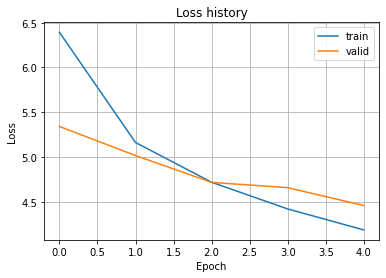

In [30]:
plt.figure()
plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='valid')
plt.title('Loss history')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

## Evaluation

## Inference